## We consider a sinusoidal transverse periodic external field

Trial: Bessel function type of root

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jn, yn, jn_zeros, yn_zeros, iv, kv
from scipy.special import spherical_jn, spherical_yn

# Set up plotting parameters
plt.rcParams.update({"figure.figsize": (12, 8), "text.usetex": True, "font.size": 12})

print("=== BESSEL FUNCTION ZEROS (First 10) ===")
print("\n1. J_0(x) zeros (most important for freezing):")
j0_zeros = jn_zeros(0, 10)
print("   ", j0_zeros)

=== BESSEL FUNCTION ZEROS (First 10) ===

1. J_0(x) zeros (most important for freezing):
    [ 2.40482556  5.52007811  8.65372791 11.79153444 14.93091771 18.07106397
 21.21163663 24.35247153 27.49347913 30.63460647]


In [3]:
from qutip import *
import numpy as np
from itertools import combinations
from scipy.special import jn_zeros

# helper: operator at one site
def spin_only_op(op, site, N):
    ops = [qeye(2) for _ in range(N)]
    ops[site] = op
    return tensor(*ops)

def g_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * np.sin(w * t)

def gdot_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * w * np.cos(w * t)

def coeff(t, args):
    return (g_t(t, args) - gdot_t(t, args)) / np.sqrt(N)


def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

def h0_ham(N, beta, Jvalue):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H0  =  empt
    
    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H0 = H0 + Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) * j_ij(Jvalue, i,j, beta)

    return H0

print("Function defined !")

Function defined !


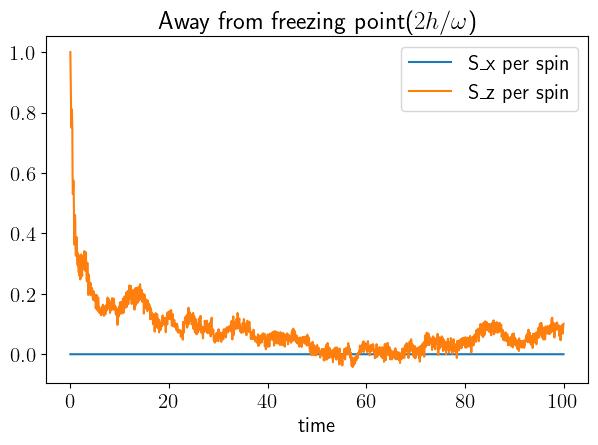

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, qeye, destroy, basis, sigmax, sesolve
from scipy.special import jn_zeros

plt.rcParams.update({"figure.figsize": (7, 4.5), "text.usetex": True, "font.size": 15})

# -------------------------------
# parameters
N = 6           # number of spins
n_ph = 25       # photon cutoff
hbar = 1.0

beta = float('inf')
Jvalue = 1
omega = 20
g0 = 3.5 * omega / 2

# time
ttop = 100

# photon operators
a = destroy(n_ph)
adag = a.dag()
I_ph = qeye(n_ph)

H0 = h0_ham(N, beta, Jvalue)
H0 = tensor(H0, qeye(n_ph)) + hbar * omega * tensor(qeye(2**N), adag*a)

# spin identity (N qubits)
I_spin_full = tensor(*[qeye(2) for _ in range(N)])

# collective Sx
Sx_spin = 0.5 * sum(spin_only_op(sigmax(), i, N) for i in range(N))

# full operator (a+a†) ⊗ Sx
V = tensor(a + adag, Sx_spin)

H0 = Qobj(H0.full())
V = Qobj(V.full())

H = H0 + V
# time-dependence
'''
    Try to get an idea if there is true-freezing at some of the drive paramter

    J_0(2 g_0 /w) = 0
    
'''
# Hamiltonian list for sesolve
#H_td = [[H, coeff]]
H_td = [H0, [V, g_t]]

# -------------------------
# initial state: photon vacuum ⊗ all spins up
spin_up = tensor(*([basis(2, 0)] * N))
psi0 = tensor(basis(n_ph, 1), spin_up)

# observables: photon number, Sx
op_nph = tensor(adag*a, I_spin_full)
op_Sx  = tensor(I_ph, Sx_spin)
op_Sz = tensor(I_ph, sum(spin_only_op(sigmaz(), i, N) for i in range(N)))

# evolve
tlist = np.linspace(0, ttop,  ttop * 20 + 1)
opts = Options(nsteps=1e5)
args = {'omega': 10.0, 'g0': g0, 'opts':opts}
result = sesolve(H_td, psi0, tlist, e_ops=[op_nph, op_Sx, op_Sz], args=args)

# extract results
nph_t = np.real(result.expect[0]) / N
Sx_t  = np.real(result.expect[1]) / N
Sz_t  = np.real(result.expect[2]) / N

# plot
#plt.plot(tlist, nph_t, label='n_ph per spin')
plt.plot(tlist, Sx_t, label='S_x per spin')
plt.plot(tlist, Sz_t, label='S_z per spin')
plt.xlabel("time")
plt.legend()

plt.title(r"Away from freezing point($2h/\omega$)")
#plt.axhline(y =1, ls = '--', color = 'green')
plt.show()

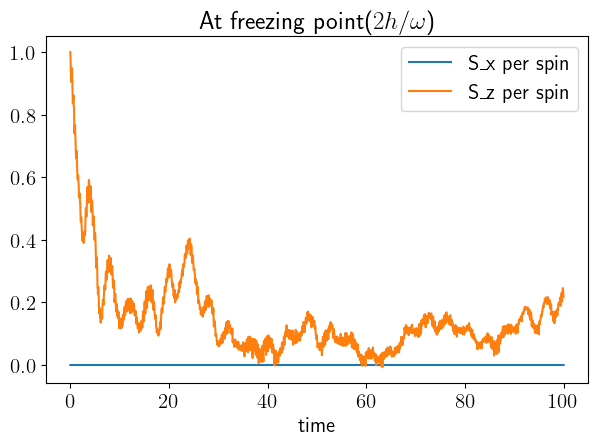

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, qeye, destroy, basis, sigmax, sesolve
from scipy.special import jn_zeros

plt.rcParams.update({"figure.figsize": (7, 4.5), "text.usetex": True, "font.size": 15})

# -------------------------------
# parameters
N = 6           # number of spins
n_ph = 25       # photon cutoff
hbar = 1.0

beta = float('inf')
Jvalue = 1
omega = 20
g0 = jn_zeros(0, 1)[0] * omega / 2

# time
ttop = 100

# photon operators
a = destroy(n_ph)
adag = a.dag()
I_ph = qeye(n_ph)

H0 = h0_ham(N, beta, Jvalue)
H0 = tensor(H0, qeye(n_ph)) + hbar * omega * tensor(qeye(2**N), adag*a)

# spin identity (N qubits)
I_spin_full = tensor(*[qeye(2) for _ in range(N)])

# collective Sx
Sx_spin = 0.5 * sum(spin_only_op(sigmax(), i, N) for i in range(N))

# full operator (a+a†) ⊗ Sx
V = tensor(a + adag, Sx_spin)

H0 = Qobj(H0.full())
V = Qobj(V.full())

H = H0 + V
# time-dependence
'''
    Try to get an idea if there is true-freezing at some of the drive paramter

    J_0(2 g_0 /w) = 0
    
'''
# Hamiltonian list for sesolve
#H_td = [[H, coeff]]
H_td = [H0, [V, g_t]]

# -------------------------
# initial state: photon vacuum ⊗ all spins up
spin_up = tensor(*([basis(2, 0)] * N))
psi0 = tensor(basis(n_ph, 1), spin_up)

# observables: photon number, Sx
op_nph = tensor(adag*a, I_spin_full)
op_Sx  = tensor(I_ph, Sx_spin)
op_Sz = tensor(I_ph, sum(spin_only_op(sigmaz(), i, N) for i in range(N)))

# evolve
tlist = np.linspace(0, ttop,  ttop * 20 + 1)
opts = Options(nsteps=1e5)
args = {'omega': 10.0, 'g0': g0, 'opts':opts}
result = sesolve(H_td, psi0, tlist, e_ops=[op_nph, op_Sx, op_Sz], args=args)

# extract results
nph_t = np.real(result.expect[0]) / N
Sx_t  = np.real(result.expect[1]) / N
Sz_t  = np.real(result.expect[2]) / N

# plot
#plt.plot(tlist, nph_t, label='n_ph per spin')
plt.plot(tlist, Sx_t, label='S_x per spin')
plt.plot(tlist, Sz_t, label='S_z per spin')
plt.xlabel("time")
plt.legend()

plt.title(r"At freezing point($2h/\omega$)")
#plt.axhline(y =1, ls = '--', color = 'green')
plt.show()

## Plot -:  $\hat{\mathcal{O}}$ vs $2h/\omega$ 

##### (Multiprocessor code)

In [3]:
from qutip import *
import numpy as np
from itertools import combinations
from scipy.special import jn_zeros

# helper: operator at one site
def spin_only_op(op, site, N):
    ops = [qeye(2) for _ in range(N)]
    ops[site] = op
    return tensor(*ops)

def g_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * np.cos(w * t)

def gdot_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * w * np.cos(w * t)

def coeff(t, args):
    return (g_t(t, args) - gdot_t(t, args)) / np.sqrt(N)


def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

def h0_ham(N, beta, Jvalue):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H0, H1, H2 =  empt, empt, empt
    
    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H0 = H0 + Qobj(tensor(id, tensor(sx, tensor(id1, tensor(sx,id2)))).full()) * j_ij(Jvalue, i,j, beta)
        
    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H1 = H1 + Qobj(tensor(id,tensor(sx,id1)).full())
        
    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sz,id1)).full())

    return H0 * 2/N, H1, H2

def run_dynamics(args):
    psi0 = args['psi0']
    tlist = args['tlist']
    N = args['N']
    beta = args['beta']
    Jvalue = args['Jvalue']
    
    H0, H1, H2 = h0_ham(N, beta, Jvalue)
    
    H0 = Qobj(H0.full())
    H1 = Qobj(H1.full())
    H2 = Qobj(H2.full())
    psi0 = Qobj(psi0.full())

    H_td = [H0, [H2, g_t]]

    result = mesolve(H_td, psi0, tlist, e_ops=[H1/N, H2/N], args=args)
    op_Sx_avg = np.average(result.expect[0])
    op_Sz_avg = np.average(result.expect[1])
    return op_Sx_avg, op_Sz_avg
    #return result

print("Function defined !")

Function defined !


Without Photon coupling

100%|██████████| 51/51 [00:00<00:00, 32768.00it/s]


Dynamics done ! 

Now plotting...


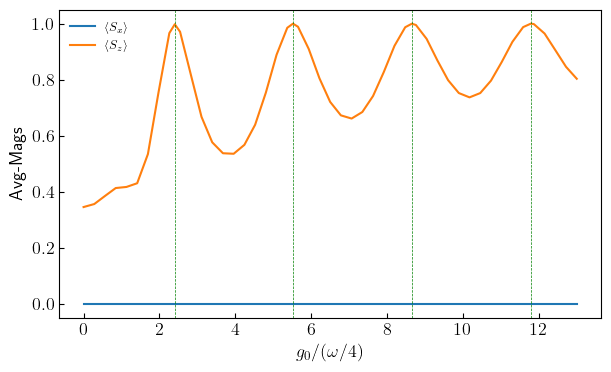

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, qeye, destroy, basis, sigmax, sesolve
from scipy.special import jn_zeros
from tqdm import tqdm
from multiprocessing import Pool


plt.rcParams.update({"figure.figsize": (7, 4), "text.usetex": True, "font.size": 13})

# -------------------------------
# Freezing points
frz = jn_zeros(0, 4)

# parameters
N = 5      # number of spins
n_ph = 25       # photon cutoff
hbar = 1.0

beta = float('inf')
Jvalue = 1
omega = 20
g0s = np.linspace(0, 13, 47) *  omega / 4
g0s = np.sort(np.append(g0s, frz * omega / 4))

# time
ttop = 10

nprocs = 5
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

# initial state: photon vacuum ⊗ all spins up
spin_up = tensor(*([basis(2, 0)] * N))
psi0 = spin_up

# evolve
tlist = np.linspace(0, ttop,  ttop * 20 + 1)

args = [{'omega': omega, 'g0': g0, 'opts':opts, 'tlist': tlist,\
    'psi0': psi0, 'beta':beta, 'Jvalue': Jvalue, 'N': N} for g0 in g0s]

results = p.map(run_dynamics, tqdm(args))

print("Dynamics done ! \n\nNow plotting...")

results = np.array(results)
Sx_avgs = results[:, 0]
Sz_avgs = results[:, 1]


plt.plot(4 * g0s/omega, Sx_avgs, label=r'$\langle S_x \rangle$')
plt.plot(4 * g0s/omega, Sz_avgs, label=r'$\langle S_z \rangle$')
plt.xlabel(r'$g_0 / ( \omega / 4)$')
plt.ylabel('Avg-Mags')

for i in frz:
    plt.axvline(x = i, ls = '--', color = 'green', lw = 0.5)



plt.tick_params(which='both', direction='in')
plt.legend(frameon=False, fontsize = 9, loc = 'best')
plt.show()



Now change the ising interaction to sxsx

In [7]:
from qutip import *
import numpy as np
from itertools import combinations
from scipy.special import jn_zeros

# helper: operator at one site
def spin_only_op(op, site, N):
    ops = [qeye(2) for _ in range(N)]
    ops[site] = op
    return tensor(*ops)

def g_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * np.cos(w * t)

def gdot_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * w * np.cos(w * t)

def coeff(t, args):
    return (g_t(t, args) - gdot_t(t, args)) / np.sqrt(N)


def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

def h0_ham(N, beta, Jvalue):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H0, H1, H2 =  empt, empt, empt
    
    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H0 = H0 + Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) * j_ij(Jvalue, i,j, beta)
        
    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H1 = H1 + Qobj(tensor(id,tensor(sx,id1)).full())
        
    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sz,id1)).full())

    return H0 * 2/N, H1, H2

def run_dynamics(args):
    psi0 = args['psi0']
    tlist = args['tlist']
    N = args['N']
    beta = args['beta']
    Jvalue = args['Jvalue']
    
    H0, H1, H2 = h0_ham(N, beta, Jvalue)
    
    H0 = Qobj(H0.full())
    H1 = Qobj(H1.full())
    H2 = Qobj(H2.full())
    psi0 = Qobj(psi0.full())

    H_td = [H0, [H1, g_t]]

    result = mesolve(H_td, psi0, tlist, e_ops=[H1/N, H2/N], args=args)
    op_Sx_avg = np.average(result.expect[0])
    op_Sz_avg = np.average(result.expect[1])
    return op_Sx_avg, op_Sz_avg
    #return result

print("Function defined !")


Function defined !


100%|██████████| 70/70 [00:00<00:00, 157.64it/s]


Dynamics done ! 

Now plotting...


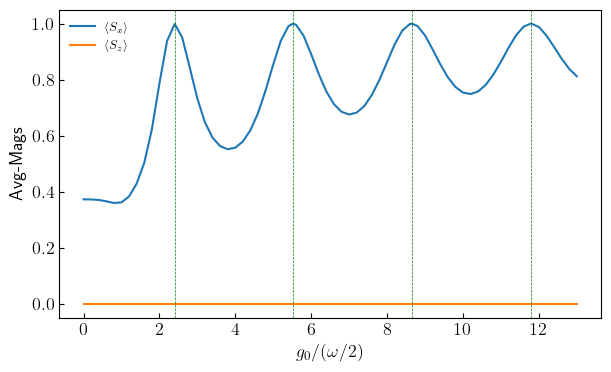

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, qeye, destroy, basis, sigmax, sesolve
from scipy.special import jn_zeros
from tqdm import tqdm
from multiprocessing import Pool


plt.rcParams.update({"figure.figsize": (7, 4), "text.usetex": True, "font.size": 13})

# -------------------------------
# Freezing points
frz = jn_zeros(0, 4)

# parameters
N = 6      # number of spins
n_ph = 25       # photon cutoff
hbar = 1.0

beta = float('inf')
Jvalue = 1
omega = 20
g0s = np.linspace(0, 13, 66) *  omega / 4
g0s = np.sort(np.append(g0s, frz * omega / 4))

# time
ttop = 10

nprocs = 10
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

# initial state: photon vacuum ⊗ all spins up
H0, H1, H2 = h0_ham(N, beta, Jvalue)
en, st = H1.eigenstates()
psi0 = st[-1]/ (np.sqrt(2)**N)

# evolve
tlist = np.linspace(0, ttop,  ttop * 20 + 1)

args = [{'omega': omega, 'g0': g0, 'opts':opts, 'tlist': tlist,\
    'psi0': psi0, 'beta':beta, 'Jvalue': Jvalue, 'N': N} for g0 in g0s]

results = p.map(run_dynamics, tqdm(args))

print("Dynamics done ! \n\nNow plotting...")

results = np.array(results)
Sx_avgs = results[:, 0]
Sz_avgs = results[:, 1]


plt.plot(4 * g0s/omega, Sx_avgs, label=r'$\langle S_x \rangle$')
plt.plot(4 * g0s/omega, Sz_avgs, label=r'$\langle S_z \rangle$')
plt.xlabel(r'$g_0 / ( \omega / 2)$')
plt.ylabel('Avg-Mags')

for i in frz:
    plt.axvline(x = i, ls = '--', color = 'green', lw = 0.5)

plt.tick_params(which='both', direction='in')
plt.legend(frameon=False, fontsize = 9, loc = 'best')
plt.show()


Now we introduce photon coupling

In [17]:
from qutip import *
import numpy as np
from itertools import combinations
from scipy.special import jn_zeros

# helper: operator at one site
def spin_only_op(op, site, N):
    ops = [qeye(2) for _ in range(N)]
    ops[site] = op
    return tensor(*ops)

def g_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * np.cos(w * t)

def gdot_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * w * np.cos(w * t)

def coeff(t, args):
    return (g_t(t, args) - gdot_t(t, args)) / np.sqrt(N)


def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

def h0_ham(N, beta, Jvalue, n_ph, hbar, omega):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H0, H1, H2 = empt, empt, empt

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H0 = H0 + Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) * j_ij(Jvalue, i,j, beta)
        
    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H1 = H1 + Qobj(tensor(id,tensor(sx,id1)).full())
        
    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sz,id1)).full())
        
    # photon operators
    a = destroy(n_ph)
    adag = a.dag()
    I_ph = qeye(n_ph)
    
    H0 = Qobj(tensor(H0, qeye(n_ph)).full())
    H1 = Qobj(tensor(H1, a + adag).full())
    H2 = Qobj(tensor(H2, I_ph).full())

    return H0 * 2/N, H1, H2

def run_dynamics(args):
    psi0 = args['psi0']
    tlist = args['tlist']
    N = args['N']
    beta = args['beta']
    Jvalue = args['Jvalue']
    n_ph = args['n_ph']
    hbar = args['hbar']
    omega = args['omega']

    H0, H1, H2 = h0_ham(N, beta, Jvalue, n_ph, hbar, omega)

    H0 = Qobj(H0.full())
    H1 = Qobj(H1.full())
    H2 = Qobj(H2.full())
    psi0 = Qobj(psi0.full())

    H_td = [H0, [H1, g_t]]

    result = mesolve(H_td, psi0, tlist, e_ops=[H1/N, H2/N], args=args)
    op_Sx_avg = np.average(result.expect[0])
    op_Sz_avg = np.average(result.expect[1])
    return op_Sx_avg, op_Sz_avg
    #return result

print("Function defined !")


Function defined !


100%|██████████| 50/50 [00:00<00:00, 11747.43it/s]


Dynamics done ! 

Now plotting...


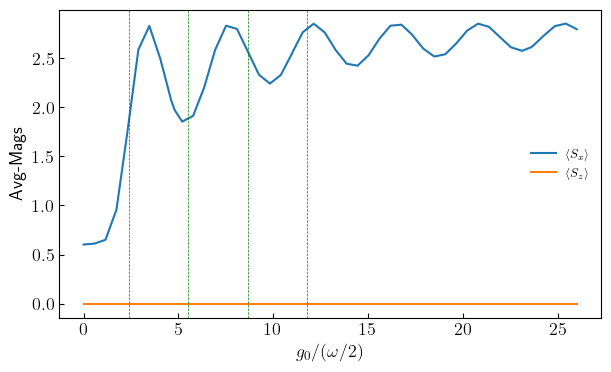

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, qeye, destroy, basis, sigmax, sesolve
from scipy.special import jn_zeros
from tqdm import tqdm
from multiprocessing import Pool


plt.rcParams.update({"figure.figsize": (7, 4), "text.usetex": True, "font.size": 13})

# -------------------------------
# Freezing points
frz = jn_zeros(0, 4)

# parameters
N = 3     # number of spins
n_ph = 5       # photon cutoff
hbar = 1.0

beta = float('inf')
Jvalue = 1
omega = 20
g0s = np.linspace(0, 13, 46) *  omega / 8
g0s = np.sort(np.append(g0s, frz * omega / 8))

# time
ttop = 10

nprocs = 10
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

# initial state: photon vacuum ⊗ all spins up
H0, H1, H2 = h0_ham(N, beta, Jvalue, n_ph, hbar, omega)
en, st = H1.eigenstates()
psi0 = st[-1]/ (np.sqrt(2)**N)

# evolve
tlist = np.linspace(0, ttop,  ttop * 20 + 1)

args = [{'omega': omega, 'g0': g0, 'opts':opts, 'tlist': tlist,\
    'psi0': psi0, 'beta':beta, 'Jvalue': Jvalue, 'N': N,\
        'n_ph': n_ph, 'hbar': hbar} for g0 in g0s]

results = p.map(run_dynamics, tqdm(args))

print("Dynamics done ! \n\nNow plotting...")

results = np.array(results)
Sx_avgs = results[:, 0]
Sz_avgs = results[:, 1]


plt.plot(16 * g0s/omega, Sx_avgs, label=r'$\langle S_x \rangle$')
plt.plot(16 * g0s/omega, Sz_avgs, label=r'$\langle S_z \rangle$')
plt.xlabel(r'$g_0 / ( \omega / 2)$')
plt.ylabel('Avg-Mags')

for i in frz:
    plt.axvline(x = i, ls = '--', color = 'green', lw = 0.5)

plt.tick_params(which='both', direction='in')
plt.legend(frameon=False, fontsize = 9, loc = 'best')
plt.show()
